In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import datetime
import math

# eda of the data

## functions and data to all the notebook

Here are some functions that will help to depurate my code, making it more efficient

In [70]:
df_melonn = pd.read_csv('/content/Datos_Prueba_DataScientist.csv')

In [71]:
# creating the impact df to normalize the data
dic_impact = {'RequestTime':['2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
                        '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01'],
               'Impact':['3','3','1','1','1','2','2','1','1','2','2','1']
}
df_impact = pd.DataFrame(dic_impact)

# adding period by Month so we can merge later at the code
df_impact['RequestTime'] = pd.to_datetime(df_impact['RequestTime']).dt.to_period('M')
# df_impact.head()

In [72]:
# create a new column to see in which shift the delivery should be made
dic_del_opt = {
    'Mismo dia entre 6:30 pm y 8:30 pm':'afternoon',
    'Siguiente dia entre 12:30 pm y 2:30 pm':'morning',
    'Siguiente dia entre las 6:30 pm y 8:30 pm':'morning'
}

df_melonn['DeliveryShift'] = df_melonn['DeliveryOption'].replace(dic_del_opt)

According to the given information and trying to prevent half-booked orders the afternoon shift will be the only one working with option 1 and the morning shift will have options 2 and 3.

In [73]:
# df with all the period types
df_melonn_all = df_melonn.copy()
df_melonn_all['RequestTime'] = pd.to_datetime(df_melonn_all['RequestTime'])
for row in range(len(df_melonn_all['DeliveryShift'])):
  if df_melonn_all['DeliveryShift'][row] == 'morning':
    df_melonn_all['RequestTime'][row] = df_melonn_all['RequestTime'][row] + datetime.timedelta(days=1)
df_melonn_all['RequestTime_M'] = pd.to_datetime(df_melonn_all['RequestTime']).dt.to_period('M')
df_melonn_all['RequestTime_W'] = pd.to_datetime(df_melonn_all['RequestTime']).dt.to_period('W')
df_melonn_all['RequestTime_D'] = pd.to_datetime(df_melonn_all['RequestTime']).dt.to_period('D')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [74]:
# you can use it when df period of time is different to Month 
def prepare_df_to_normalize(df_all,period_letter):

  ''' recieve the data frame with all the three diferent time periods and a period letter to group by 
  and return a df ready to be normalize.
  
  Use it when you have a period different to Month'''

  df_melonn = df_all[['OrderId', 'RequestTime_M', f'RequestTime_{period_letter}','DeliveryOption', 'DeliveryShift']]
  df_melonn.columns = ['OrderId', 'RequestTime', f'RequestTime_{period_letter}','DeliveryOption', 'DeliveryShift']

  df_shifts = df_melonn.groupby(['DeliveryShift',f'RequestTime_{period_letter}','RequestTime'])['OrderId'].count()
  df_shifts = df_shifts.to_frame(name='deliveries').reset_index()

  return df_shifts

In [75]:
# normalize the number of deliveries by shift
def normalize_df(df_to_normalize, df_impact):

  ''' recieve two df, the first one is the df to normalize and the second one is the dataframe that will help
  us to normalize the first df'''
  
  df_normalized = df_to_normalize.merge(df_impact, how='left',on='RequestTime')
  df_normalized['Impact'].fillna(0,inplace=True)
  df_normalized = df_normalized.astype({'Impact':'int'})
  df_normalized['deliveries_n'] = df_normalized['deliveries']+((df_normalized['Impact']/100)*df_normalized['deliveries'])
  
  return df_normalized

To normalize the data it takes the impact as a variation that needs to be included inside the process to have a more accurate prediction.

In [76]:
# recieving the normalized df and prepare it to be plot
def prepare_ploting_df(df_to_plot, time_column):

  ''' recieves two parameters "df to be plot" and the column that contains the correct period
  of time and returns a df ready to be plot.'''
  
  df_to_plot.index = df_to_plot[time_column]
  try:
    df_to_plot.index = df_to_plot.index.to_timestamp()
  except:
    print('already a timestamp')
  df_to_plot1 = df_to_plot[['DeliveryShift','deliveries_n']]
  df_to_plot2 = df_to_plot1.reset_index()
  df_to_plot3 = df_to_plot2.pivot(index=time_column,columns='DeliveryShift',values='deliveries_n').reset_index()

  return df_to_plot3

In [77]:
# ploting the normalize deliveries by shift and month
def plot_the_df(df_to_plot, time_column,time_period,tick_list=[]):

  '''recieve the df to be plot, the name of the column that contains the correc period of time as a string,
  the name of the period of time that correspond as a string to make the title plot and a optionally it 
  recieves a list with the tick names'''

  plt.figure(figsize=(15, 7)) 
  plt.plot(df_to_plot[time_column], df_to_plot["afternoon"], label='afternoon',linestyle='dashed')
  plt.plot(df_to_plot[time_column], df_to_plot["morning"], label='morning')
  plt.legend(loc='upper center')
  plt.title(f"Deliveries per shift by {time_period}")
  plt.xlabel("date")
  plt.ylabel("deliveries")
  if len(tick_list) > 1:
    plt.xticks(df_to_plot[time_column],tick_list)

## deliveries by month

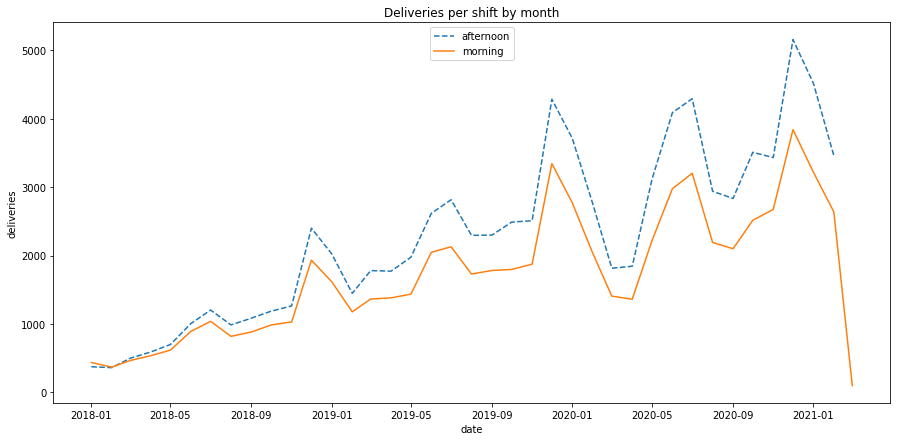

In [78]:
df_melonn_M = df_melonn_all.copy()
df_shifts_month = df_melonn_M.groupby(['DeliveryShift','RequestTime_M'])['OrderId'].count()
df_shifts_month = df_shifts_month.to_frame(name='deliveries').reset_index()
# changing columns names to be able to use the functions
df_shifts_month.columns = ['DeliveryShift', 'RequestTime', 'deliveries']
# normalize the df by months
df_melonn_n = normalize_df(df_shifts_month, df_impact)
# geting the df ready to be plot
df_plot_M = prepare_ploting_df(df_melonn_n,"RequestTime")
#ploting the df
plot_the_df(df_plot_M, "RequestTime","month")

Looking at the monthly plot we can see some stationary patterns where we can find highs at the middle and end of the year probably impulsed by the holidays and the dynamism of the economy during this time of the year. Also, we can observe a sales increase through the years with higher fluctuation during the recent years probably because of the Covid situation.

Finally, we can appreciate how the afternoon shift needs to enlist more orders.

## Deliveries by week

already a timestamp


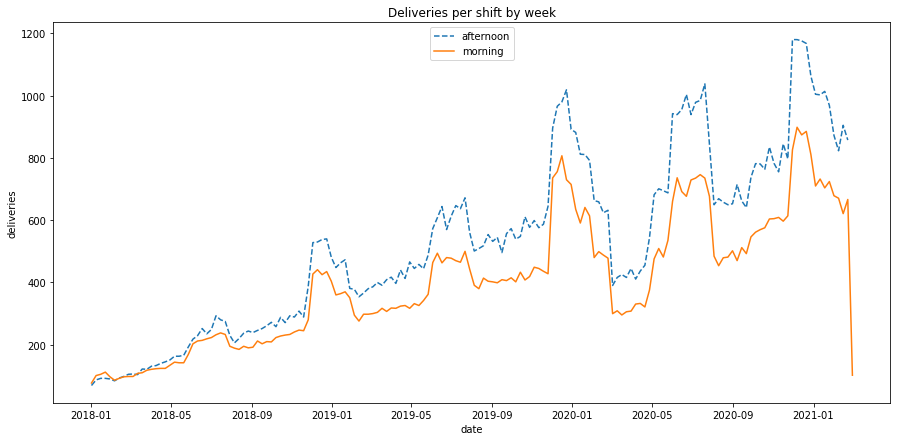

In [79]:
df_shifts_week = prepare_df_to_normalize(df_melonn_all,"W")
# normalize the df by months
df_melonn_w = normalize_df(df_shifts_week, df_impact)

# aditional steps to make the code work due to the week fromat
df_melonn_w["RequestTime_W"] = df_melonn_w['RequestTime_W'].apply(lambda r: r.start_time)
df_melonn_w.index = df_melonn_w["RequestTime_W"]
df_melonn_w.columns = ['DeliveryShift','RequestTime_We','RequestTime','deliveries','Impact','deliveries_n']
df_melonn_w1 = df_melonn_w.groupby(['DeliveryShift','RequestTime_W'])['deliveries_n'].sum().reset_index()

# geting the df ready to be plot
df_plot_W = prepare_ploting_df(df_melonn_w1,"RequestTime_W")
#ploting the df
plot_the_df(df_plot_W, "RequestTime_W","week")

Here we can reaffirm the behavior observed in the monthly plot, some highs during the end and the middle of the year, fewer fluctuations during the rest of the year but it looks like during those weeks the sales number is growing at a similar pace. This could indicate an increase in regular clients.

Except for a short period at the begging of 2018 the afternoon shift had to enlist more orders than the morning shift even if it does not seem to have big differences from each other.

In [80]:
# adding a columns with the week number 
def add_weeknumber(data_row):
  return data_row.isocalendar()[1]
df_plot_W['week_number'] = df_plot_W['RequestTime_W'].apply(add_weeknumber)

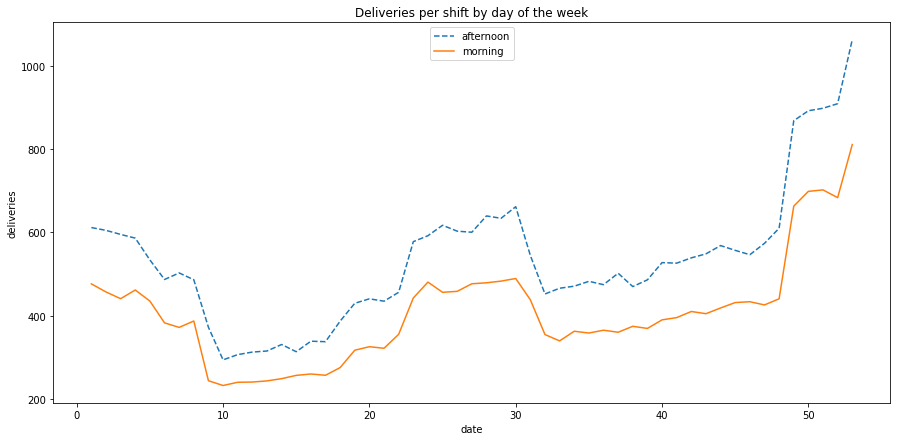

In [81]:
#ploting the df
df_plot_W2 = df_plot_W.groupby('week_number').mean().reset_index()
plot_the_df(df_plot_W2, "week_number","day of the week")

Here we are comparing the behavior of the sales through the year without taking into account which year is. We can infer that people prefer to get their orders the same day then wait until the next day.

## Delivieries by day


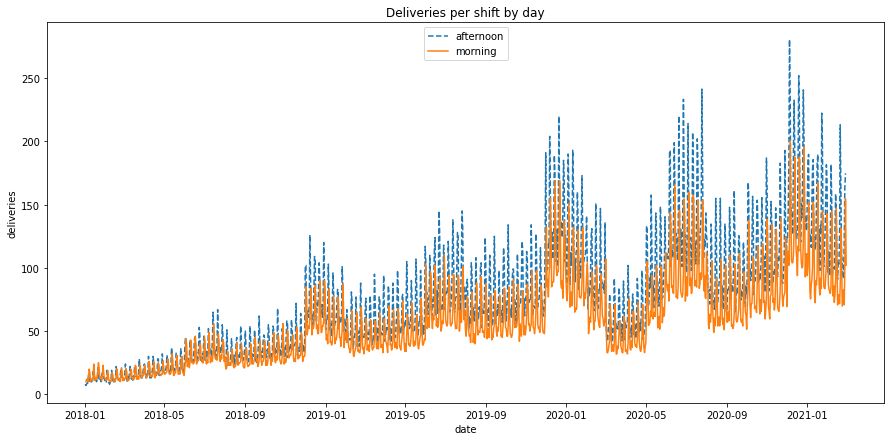

In [82]:
df_shifts_day = prepare_df_to_normalize(df_melonn_all,"D")
# normalize the df by months
df_melonn_d = normalize_df(df_shifts_day, df_impact)
# geting the df ready to be plot
df_plot_D = prepare_ploting_df(df_melonn_d,"RequestTime_D")
#ploting the df
plot_the_df(df_plot_D, "RequestTime_D","day")

The plot is not saying too much so we will see the behavior during the week to see if we have new insights.

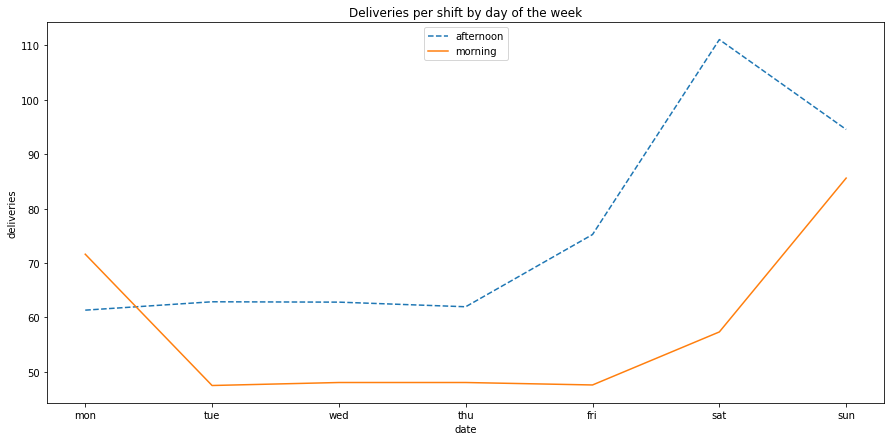

In [83]:
# adding a columns with the week day where 0 is monday and sunday 6 
def add_weekday(data_row):
  return data_row.weekday()
df_plot_D['week_Day'] = df_plot_D['RequestTime_D'].apply(add_weekday)
#ploting the df
df_plot_D2 = df_plot_D.groupby('week_Day').mean().reset_index()
ticks_list=['mon','tue','wed','thu','fri','sat','sun']
plot_the_df(df_plot_D2, "week_Day","day of the week",ticks_list)

It looks that within a week they still keep the tendency to have more orders booked during the more active time, in this situation the weekends. Even if the tendency to have more orders for the afternoon shift continues it changes only on Mondays.

# prediction

In [84]:
from fbprophet import Prophet

In [89]:
df_day_aft = df_plot_D[['RequestTime_D','afternoon']]
df_day_aft.columns = ['ds','y']
df_day_mor = df_plot_D[['RequestTime_D','morning']]
df_day_mor.columns = ['ds','y']

In [96]:
# forecasting daily sales for the afternoon shift
melonn_model_aft = Prophet(interval_width=0.95,daily_seasonality=True).fit(df_day_aft)
future_aft = melonn_model_aft.make_future_dataframe(periods=30,freq='D')
forecast_aft_sales = melonn_model_aft.predict(future_aft)

In [97]:
# forecasting daily sales for the morning shift
melonn_model_mor = Prophet(interval_width=0.95,daily_seasonality=True).fit(df_day_mor)
future_mor = melonn_model_mor.make_future_dataframe(periods=30,freq='D')
forecast_mor_sales = melonn_model_mor.predict(future_mor)

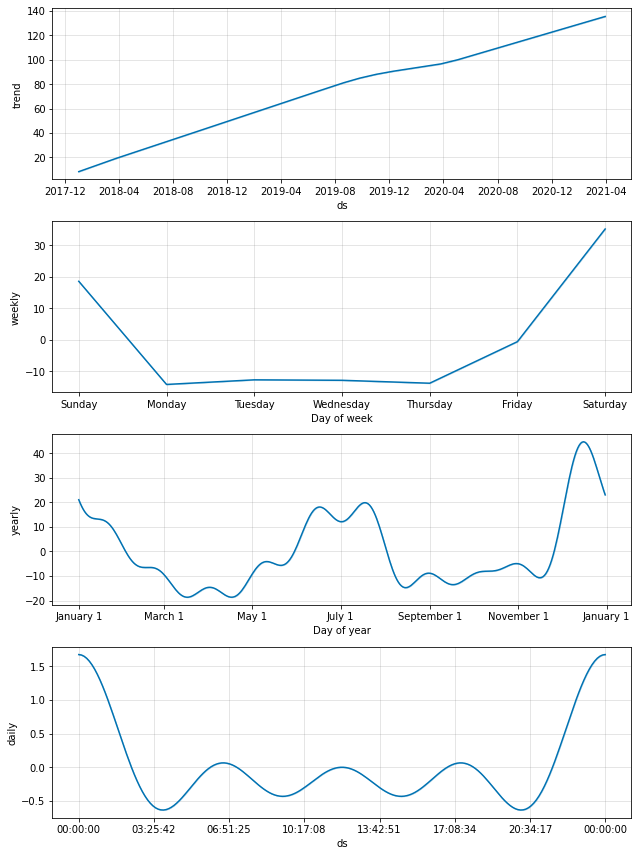

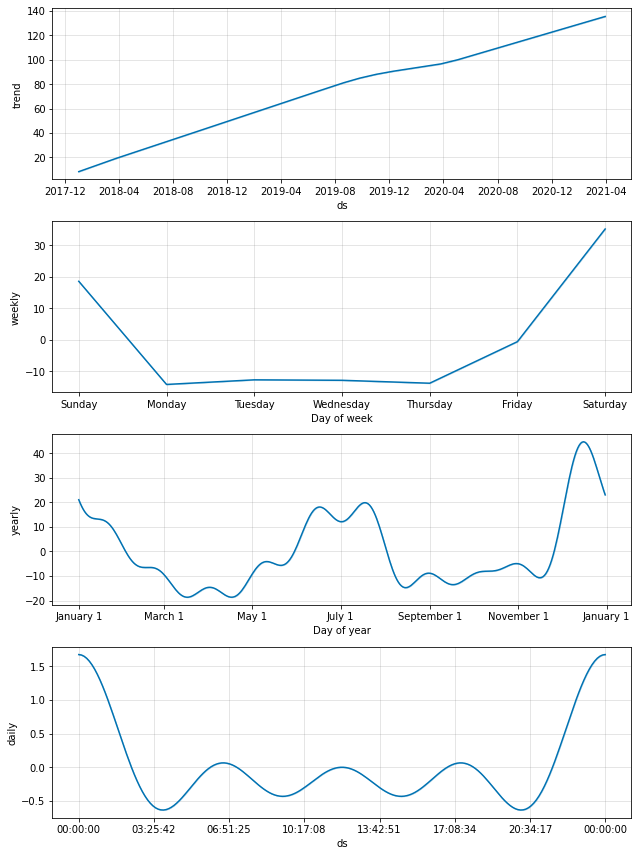

In [112]:
melonn_model_aft.plot_components(forecast_aft_sales)

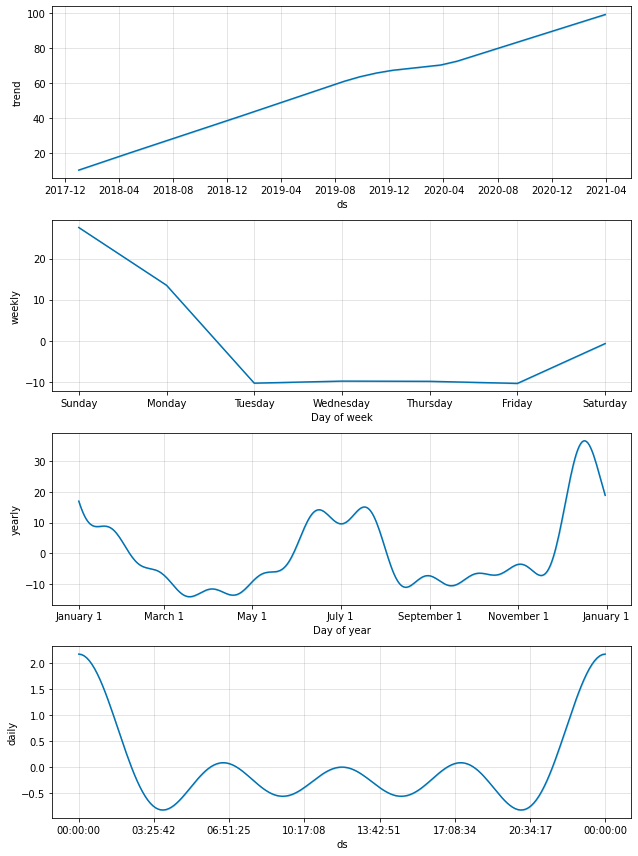

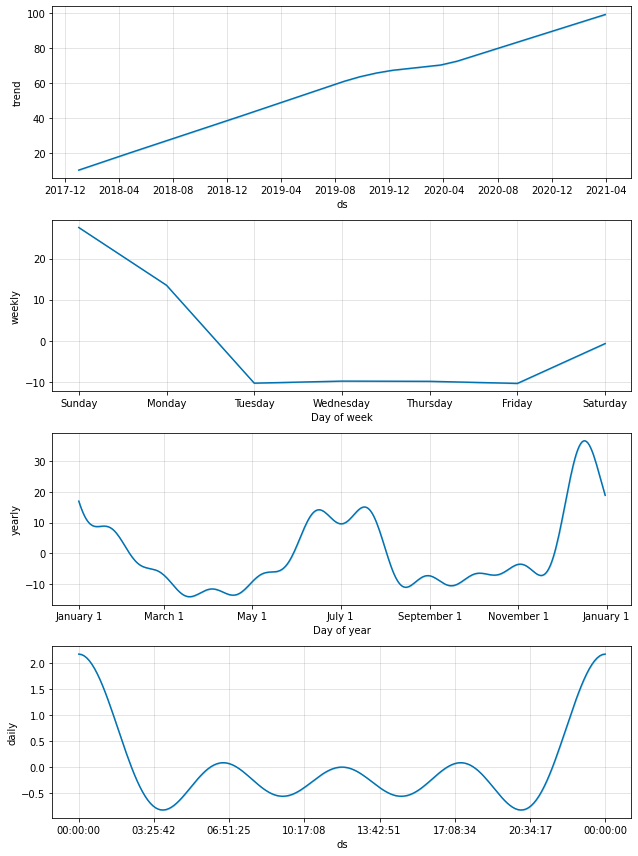

In [103]:
melonn_model_mor.plot_components(forecast_mor_sales)

The components plots are a good way to confirm that the model is working similarly to what we observed before in the previous plots.

In [107]:
# get only the relevant data
aft_sales = forecast_aft_sales[['ds','yhat']]
mor_sales = forecast_mor_sales[['ds','yhat']]

In [ ]:
# round to the next number to make sure a delivery is not half pack
df_forecast_aft = aft_sales[aft_sales.index > 1154]
df_forecast_aft['afternoon_sales'] = df_forecast_aft['yhat'].apply(lambda s: math.ceil(s))

df_forecast_mor = mor_sales[mor_sales.index > 1154]
df_forecast_mor['morning_sales'] = df_forecast_mor['yhat'].apply(lambda s: math.ceil(s))

In [ ]:
df_merge = df_forecast_aft.merge(df_forecast_mor, how='inner',on='ds')
df_final = df_merge[['ds','afternoon_sales','morning_sales']]
df_final['morning_workers'] = (df_final['morning_sales']/20).apply(lambda s: math.ceil(s))
df_final['afternoon_workers'] = (df_final['afternoon_sales']/20).apply(lambda s: math.ceil(s))

In [128]:
df_final

,ds,afternoon_sales,morning_sales,morning_workers,afternoon_workers
0,2021-03-01,111,106,6,6
1,2021-03-02,112,82,5,6
2,2021-03-03,111,82,5,6
3,2021-03-04,109,81,5,6
4,2021-03-05,122,80,4,7
5,2021-03-06,157,89,5,8
6,2021-03-07,140,117,6,7
7,2021-03-08,106,103,6,6
8,2021-03-09,107,78,4,6
9,2021-03-10,106,78,4,6


**sales and number of workers for the next month**

in the table above we can find the number of sales that need to be enlisted for each shift, also there is the number of workers for each shift if the productivity by a worker is 5 orders per hour. 

```
df_final['morning_workers'].sum() 
output: 148

df_final['afternoon_workers'].sum() 
output: 199
```
The total of workers on the morning shift must be 148 and the total of workers on the afternoon shift must be 199 during the next month.


In [135]:
df_final['weeks'] = pd.to_datetime(df_final['ds']).dt.to_period('W')

df_forecast_shifts_aft = df_final.groupby(['weeks'])['afternoon_sales'].sum()
df_forecast_shifts_aft = df_forecast_shifts_aft.to_frame(name='afternoon_orders').reset_index()
df_forecast_shifts_mor = df_final.groupby(['weeks'])['morning_sales'].sum()
df_forecast_shifts_mor = df_forecast_shifts_mor.to_frame(name='morning_orders').reset_index()

In [137]:
df_weeks_forecast = df_forecast_shifts_aft.merge(df_forecast_shifts_mor,how='inner',on='weeks')
df_weeks_forecast

,weeks,afternoon_orders,morning_orders
0,2021-03-01/2021-03-07,862,637
1,2021-03-08/2021-03-14,831,616
2,2021-03-15/2021-03-21,824,607
3,2021-03-22/2021-03-28,843,617
4,2021-03-29/2021-04-04,328,262


In the table above we can see how many workers Melonn should hire by every week, the last week have significantly less amount of workers due to we only forecasting march which means that the four days of April are not adding to the total of that week. We can also appreciate that most of the workers will be on the afternoon shift